# 0. Setup

In [18]:
# Core
import random, hashlib, math 
from pathlib import Path

# Data
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Images
from PIL import Image
import seaborn as sns   

# deep-features
import torch
import torchvision.transforms as T
import torchvision.models as models
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# metrics
from callbacks import find_best_threshold
from sklearn.metrics import  confusion_matrix, roc_curve, auc

In [19]:



LABEL_F =Path(
    "/home/nexton/Documents/mlex/ml_exercise_therapanacea/label_train.txt"
)
IMG_DIR = Path("/home/nexton/Documents/mlex/ml_exercise_therapanacea/train_img")
 
SEED = 55
rng = random.Random(SEED)

# Load labels ⇢ DataFrame
df = pd.read_csv(LABEL_F, header=None, names=[ "label"])
df["filepath"] = df.index.map(lambda i: IMG_DIR / f"{(i+1):06d}.jpg")
df.head()


,label,filepath
0,1,/home/nexton/Documents/mlex/ml_exercise_therap...
1,1,/home/nexton/Documents/mlex/ml_exercise_therap...
2,1,/home/nexton/Documents/mlex/ml_exercise_therap...
3,1,/home/nexton/Documents/mlex/ml_exercise_therap...
4,1,/home/nexton/Documents/mlex/ml_exercise_therap...


# 1. Class balance & basic stats

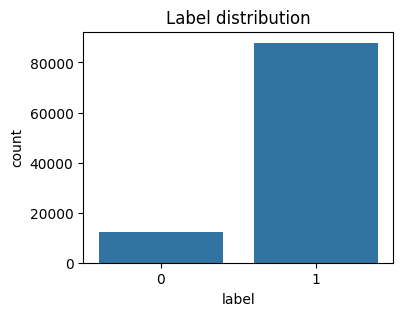

Class imbalance (ratio %):
label
1    87.9
0    12.1
Name: proportion, dtype: float64


In [3]:
plt.figure(figsize=(4, 3))
sns.countplot(x="label", data=df)
plt.title("Label distribution")
plt.show()

imbalance = df["label"].value_counts(normalize=True)
print("Class imbalance (ratio %):")
print(round(imbalance * 100, 2))


 Class 0 constitutes 12.1% of the dataset, indicating a need for stratified splits, class weights, data augmentation, and upsampling to address the imbalance.

# 2. Image-level metadata

In [7]:
width_counts = df["filepath"].apply(lambda path: Image.open(path).size[0]).value_counts()
height_counts = df["filepath"].apply(lambda path: Image.open(path).size[1]).value_counts()

print("Width occurrence counts:")
print(width_counts)
print("\nHeight occurrence counts:")
print(height_counts)

Width occurrence counts:
filepath
64    100000
Name: count, dtype: int64

Height occurrence counts:
filepath
64    100000
Name: count, dtype: int64


All images have a uniform size of 64x64 pixels.

# 3. Quick visual scan

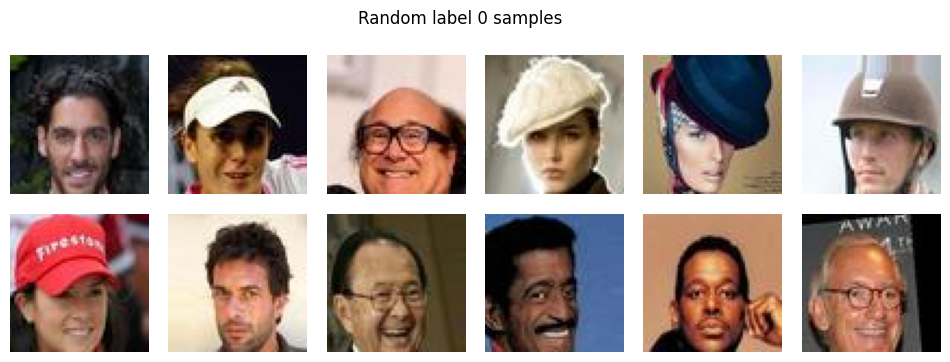

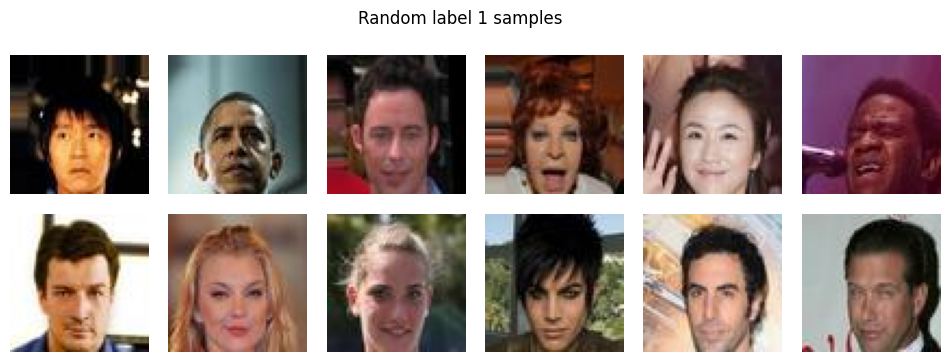

In [8]:
def show_samples(label, n=12, cols=6):
    subset = df[df.label == label].sample(
        n=min(n, len(df[df.label == label])), random_state=SEED
    )
    rows = math.ceil(len(subset) / cols)
    fig = plt.figure(figsize=(cols * 2, rows * 2))
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.2)
    for ax, (_, row) in zip(grid, subset.iterrows()):
        ax.imshow(Image.open(row.filepath))
        ax.axis("off")
    fig.suptitle(f"Random label {label} samples")
    plt.show()


show_samples(0)
show_samples(1)


The semantic class is currently unclear and requires further investigation, as it appears to be noise.

In [14]:
def hash_img(path, hash_size=8):
    with Image.open(path).resize((hash_size, hash_size)).convert("L") as im:
        return hashlib.sha1(np.asarray(im).tobytes()).hexdigest()

df["ahash"] = df["filepath"].apply(hash_img)
dupe_hashes = df["ahash"].value_counts()
suspicious = dupe_hashes[dupe_hashes > 1]
print(f"Exact / near-pixel dupes: {len(suspicious)} groups with potential label mismatches")

# Identify and print paths of images with the same hash but different labels
for h in suspicious.index:
    group = df[df.ahash == h]
    unique_labels = group["label"].unique()
    if len(unique_labels) > 1:  # Check if there are different labels in the group
        print(f"Hash: {h} has different labels: {unique_labels}")
        for _, row in group.iterrows():
            print(f"Path: {row.filepath}, Label: {row.label}")


Exact / near-pixel dupes: 27 groups with potential label mismatches


The dataset contains 27 duplicate images; however, there are no similar images shared between the two classes.

# 4.Feature-space sanity (pre-trained CNN + (t-SNE, PCA))

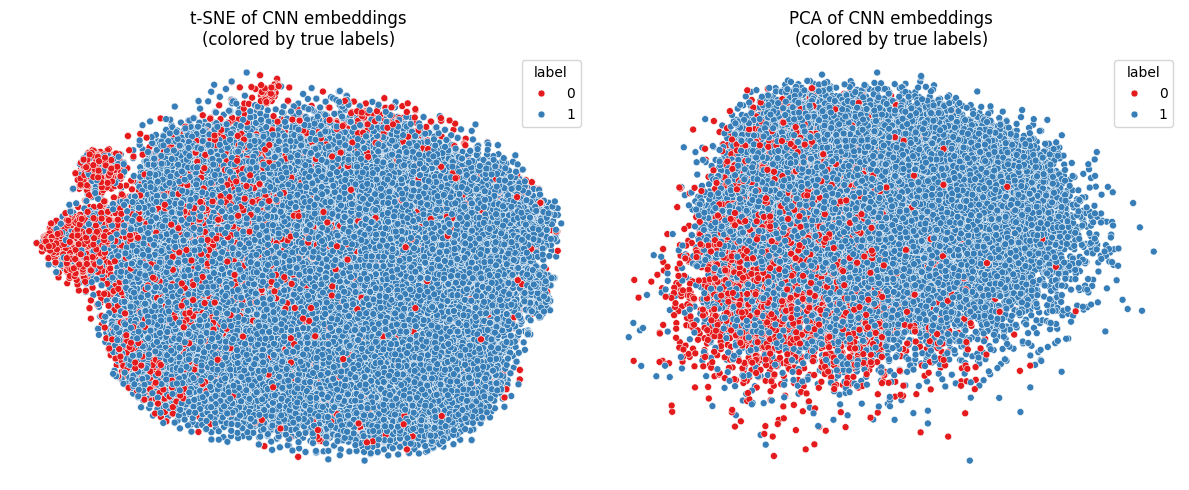

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device).eval()
transform = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def embed(path):
    with Image.open(path) as im:
        x = transform(im).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = backbone.conv1(x)
            feat = backbone.bn1(feat)
            feat = backbone.relu(feat)
            feat = backbone.maxpool(feat)
            feat = backbone.layer1(feat)
            feat = backbone.layer2(feat)
            feat = backbone.layer3(feat)
            feat = backbone.layer4(feat)
            feat = backbone.avgpool(feat)
            feat = torch.flatten(feat, 1)
            feat = feat.squeeze().cpu().numpy()
    return feat


sample_df = df.sample(n=min(50000, len(df)), random_state=SEED)
embeds = np.vstack([embed(p) for p in sample_df.filepath])

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, init="pca", random_state=SEED).fit_transform(
    embeds
)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeds)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot t-SNE results
sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=sample_df.label, palette="Set1", s=25, ax=ax1)
ax1.set_title("t-SNE of CNN embeddings\n(colored by true labels)")
ax1.axis("off")

# Plot PCA results
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=sample_df.label, palette="Set1", s=25, ax=ax2)
ax2.set_title("PCA of CNN embeddings\n(colored by true labels)")
ax2.axis("off")

plt.tight_layout()
plt.show()


Both PCA and t-SNE suggest that the two classes are somewhat distinct, even though this distinction is not visually apparent to me due.

# 5. Results

In [20]:
df_result_resnet = pd.read_csv(
    "/home/nexton/Documents/mlex/ml_exercise_therapanacea/resnet_train.proba",
    header=None,
    names=["prob_resnet"],
)
df_result_efficientnet = pd.read_csv(
    "/home/nexton/Documents/mlex/ml_exercise_therapanacea/efficientnet_train.proba",
    header=None,
    names=["prob_efficientnet"],
)

df = pd.concat([df, df_result_resnet, df_result_efficientnet], axis=1)


In [21]:
labels = df["label"].to_numpy()
val_split = 0.2

train_val_idx, test_idx = train_test_split(
    df.index,
    test_size=0.10,  # 10% of data for testing
    stratify=labels,
    random_state=42,
)

train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=val_split,
    stratify=labels[train_val_idx],
    random_state=SEED,
)

# Add set column to df
df["set"] = "train"
df.loc[val_idx, "set"] = "val"
df.loc[test_idx, "set"] = "test"


In [22]:
# Compute metrics for each model and set
def compute_metrics(y_true, y_score, threshold=None):
    if threshold is None:
        threshold, _ = find_best_threshold(y_true, y_score,steps=1000)
    
    # Get predictions using threshold
    y_pred = (y_score >= threshold).astype(int)
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Compute metrics
    far = fp / (fp + tn + 1e-9)  # False Acceptance Rate
    frr = fn / (fn + tp + 1e-9)  # False Rejection Rate
    hter = 0.5 * (far + frr)     # Half Total Error Rate
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    return {
        'threshold': threshold,
        'hter': hter,
        'far': far,
        'frr': frr,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }

# Compute metrics for each model and set
models = ['resnet', 'efficientnet']
sets = ['train', 'val', 'test']
metrics = {}

for model in models:
    metrics[model] = {}
    # First compute threshold on validation set
    val_mask = df['set'] == 'val'
    val_metrics = compute_metrics(
        df.loc[val_mask, 'label'].values,
        df.loc[val_mask, f'prob_{model}'].values
    )
    threshold = val_metrics['threshold']
    
    # Then compute metrics for all sets using this threshold
    for set_name in sets:
        set_mask = df['set'] == set_name
        metrics[model][set_name] = compute_metrics(
            df.loc[set_mask, 'label'].values,
            df.loc[set_mask, f'prob_{model}'].values,
            threshold
        )


# Print metrics summary
print("\nMetrics Summary:")
print("-" * 80)
for model in models:
    print(f"\n{model.upper()}:")
    print("-" * 40)
    for set_name in sets:
        m = metrics[model][set_name]
        print(f"\n{set_name.upper()} set:")
        print(f"Threshold: {m['threshold']:.3f}")
        print(f"HTER: {m['hter']:.3f}")
        print(f"FAR: {m['far']:.3f}")
        print(f"FRR: {m['frr']:.3f}")
        print(f"ROC AUC: {m['roc_auc']:.3f}")



Metrics Summary:
--------------------------------------------------------------------------------

RESNET:
----------------------------------------

TRAIN set:
Threshold: 0.959
HTER: 0.036
FAR: 0.004
FRR: 0.068
ROC AUC: 0.998

VAL set:
Threshold: 0.959
HTER: 0.070
FAR: 0.054
FRR: 0.087
ROC AUC: 0.979

TEST set:
Threshold: 0.959
HTER: 0.069
FAR: 0.058
FRR: 0.081
ROC AUC: 0.979

EFFICIENTNET:
----------------------------------------

TRAIN set:
Threshold: 0.930
HTER: 0.037
FAR: 0.006
FRR: 0.067
ROC AUC: 0.995

VAL set:
Threshold: 0.930
HTER: 0.072
FAR: 0.062
FRR: 0.083
ROC AUC: 0.979

TEST set:
Threshold: 0.930
HTER: 0.081
FAR: 0.083
FRR: 0.080
ROC AUC: 0.977


### Model Performance Analysis:

Both models achieve excellent performance with ROC AUC scores above 0.98 across all datasets.

ResNet demonstrates superior performance on the test set:
- Lower HTER (0.069 vs 0.081)
- Better generalization despite simpler architecture
- More balanced false positive/negative rates

EfficientNet shows higher false acceptance rates, which could be problematic.

Based on these results, we'll proceed with ResNet as our final model.